In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary

from sklearn.model_selection import train_test_split


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
from tqdm import tqdm
import numpy as np
import os

print ('Using PyTorch version :', torch . __version__ )
if torch . cuda . is_available () :
  print ('Using GPU , device name :', torch . cuda . get_device_name (0) )
  device = torch . device ('cuda')
else :
  print ('No GPU found , using CPU instead .')
  device = torch . device ('cpu')


Using PyTorch version : 2.6.0+cu124
Using GPU , device name : Tesla T4


In [ ]:
X = []
Z = []
img_dir = '/content/drive/MyDrive/Kitchen_items'
bowl_dir = img_dir + '/Bowl'
glass_dir = img_dir + '/Glass'
knife_dir = img_dir + '/Knife'
spoon_dir = img_dir + '/Spoon'
chopsticks_dir = img_dir + '/Chopsticks'
img_size = 224

def assign_label(img,items):
    return items

def make_train_data(items_dir,DIR):
      for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,items_dir)
        path = os.path.join(DIR,img)

        img = cv2.imread(path,cv2.IMREAD_COLOR)
        if img is None:
            print(f"Không thể đọc được ảnh từ đường dẫn: {path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))
        X.append(np.array(img))
        Z.append(str(label))

In [ ]:
make_train_data('Bowl',bowl_dir)
make_train_data('Glass',glass_dir)
make_train_data('Knife',knife_dir)
make_train_data('Spoon',spoon_dir)
make_train_data('Chopsticks',chopsticks_dir)

100%|██████████| 2002/2002 [04:34<00:00,  7.29it/s]


In [ ]:
#AlexNet
alexnet = models.alexnet(pretrained=True)

# Đóng băng các tầng Conv để fine-tune
for param in alexnet.features.parameters():
    param.requires_grad = False

# Tùy chỉnh classifier cho 5 lớp
alexnet.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(9216, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, 5)
)

alexnet = alexnet.to(device)
summary(alexnet, (3, 224, 224))

transform = {
    "train": transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),  # Giảm góc xoay
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=10),  # Giảm dịch chuyển và shear
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3)),  # Giảm xác suất xóa
    ]),
    "val": transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# 3. Chia tập dữ liệu với stratify
# Giả định X và Z đã được định nghĩa (X là ảnh, Z là nhãn)
label_encoder = LabelEncoder()
Z_encoded = label_encoder.fit_transform(Z)
Z_tensor = torch.tensor(Z_encoded, dtype=torch.long)

X_train, X_temp, y_train, y_temp = train_test_split(X, Z_tensor, test_size=0.3, random_state=42, stratify=Z_tensor)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 4. Tạo DataLoader
train_dataset = KitchenDataset(X_train, y_train, transform=transform["train"])
val_dataset = KitchenDataset(X_val, y_val, transform=transform["val"])
test_dataset = KitchenDataset(X_test, y_test, transform=transform["test"])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 160MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:

#Định nghĩa phương thức tối ưu và khởi tạo trong số
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, alexnet.parameters()), lr=0.001, weight_decay=0.0001) #Cần giảm lr
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

#huấn luyện mô hình

train_losses = []
val_losses = []
train_accs = []
val_accs = []

num_epochs = 50
best_val_loss = float('inf')
patience = 10
counter = 0

for epoch in range(num_epochs):
    alexnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = alexnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    alexnet.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = alexnet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(alexnet.state_dict(), '/content/drive/MyDrive/bestmodel/alexnet_best_model.pth')
    else:
        counter += 1
    if counter >= patience:
        print("Early stopping triggered")
        break


Epoch 1/50, Train Loss: 0.8694, Train Acc: 78.00%, Val Loss: 0.2125, Val Acc: 92.81%
Epoch 2/50, Train Loss: 0.4126, Train Acc: 86.13%, Val Loss: 0.1818, Val Acc: 93.89%
Epoch 3/50, Train Loss: 0.3770, Train Acc: 86.93%, Val Loss: 0.1465, Val Acc: 94.98%
Epoch 4/50, Train Loss: 0.3418, Train Acc: 88.51%, Val Loss: 0.1498, Val Acc: 95.05%
Epoch 5/50, Train Loss: 0.3399, Train Acc: 89.02%, Val Loss: 0.1308, Val Acc: 95.66%
Epoch 6/50, Train Loss: 0.3346, Train Acc: 89.06%, Val Loss: 0.1665, Val Acc: 94.17%
Epoch 7/50, Train Loss: 0.3151, Train Acc: 89.57%, Val Loss: 0.1763, Val Acc: 93.35%
Epoch 8/50, Train Loss: 0.3183, Train Acc: 89.89%, Val Loss: 0.1282, Val Acc: 95.86%
Epoch 9/50, Train Loss: 0.2864, Train Acc: 90.77%, Val Loss: 0.1285, Val Acc: 95.59%
Epoch 10/50, Train Loss: 0.3035, Train Acc: 89.89%, Val Loss: 0.1375, Val Acc: 95.52%
Epoch 11/50, Train Loss: 0.2750, Train Acc: 91.14%, Val Loss: 0.1216, Val Acc: 96.68%
Epoch 12/50, Train Loss: 0.2661, Train Acc: 91.48%, Val Loss: 0

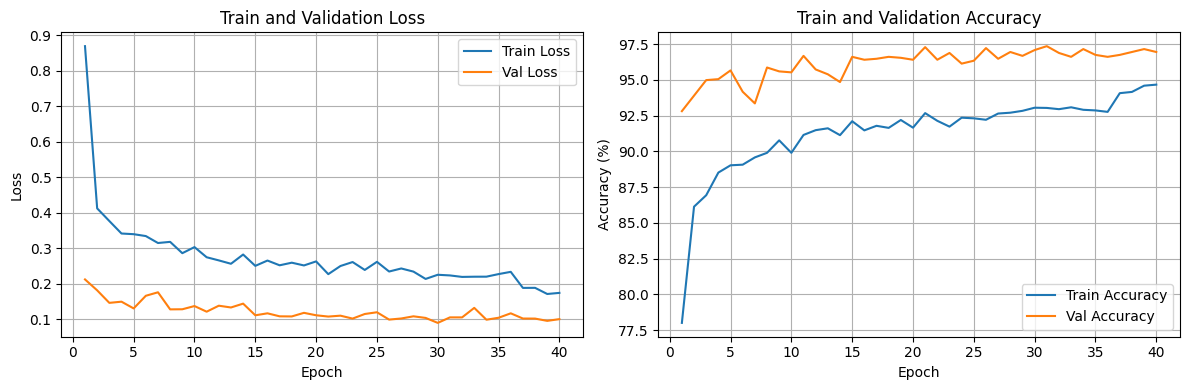


Classification Report:
              precision    recall  f1-score   support

        Bowl       0.99      0.97      0.98       273
  Chopsticks       0.97      0.99      0.98       301
       Glass       0.95      0.97      0.96       300
       Knife       0.99      0.93      0.96       300
       Spoon       0.95      0.98      0.96       300

    accuracy                           0.97      1474
   macro avg       0.97      0.97      0.97      1474
weighted avg       0.97      0.97      0.97      1474



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 8. Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 9. Classification Report (bao gồm Recall)
print("\nClassification Report:")
print(classification_report(val_labels, val_preds, target_names=label_encoder.classes_))

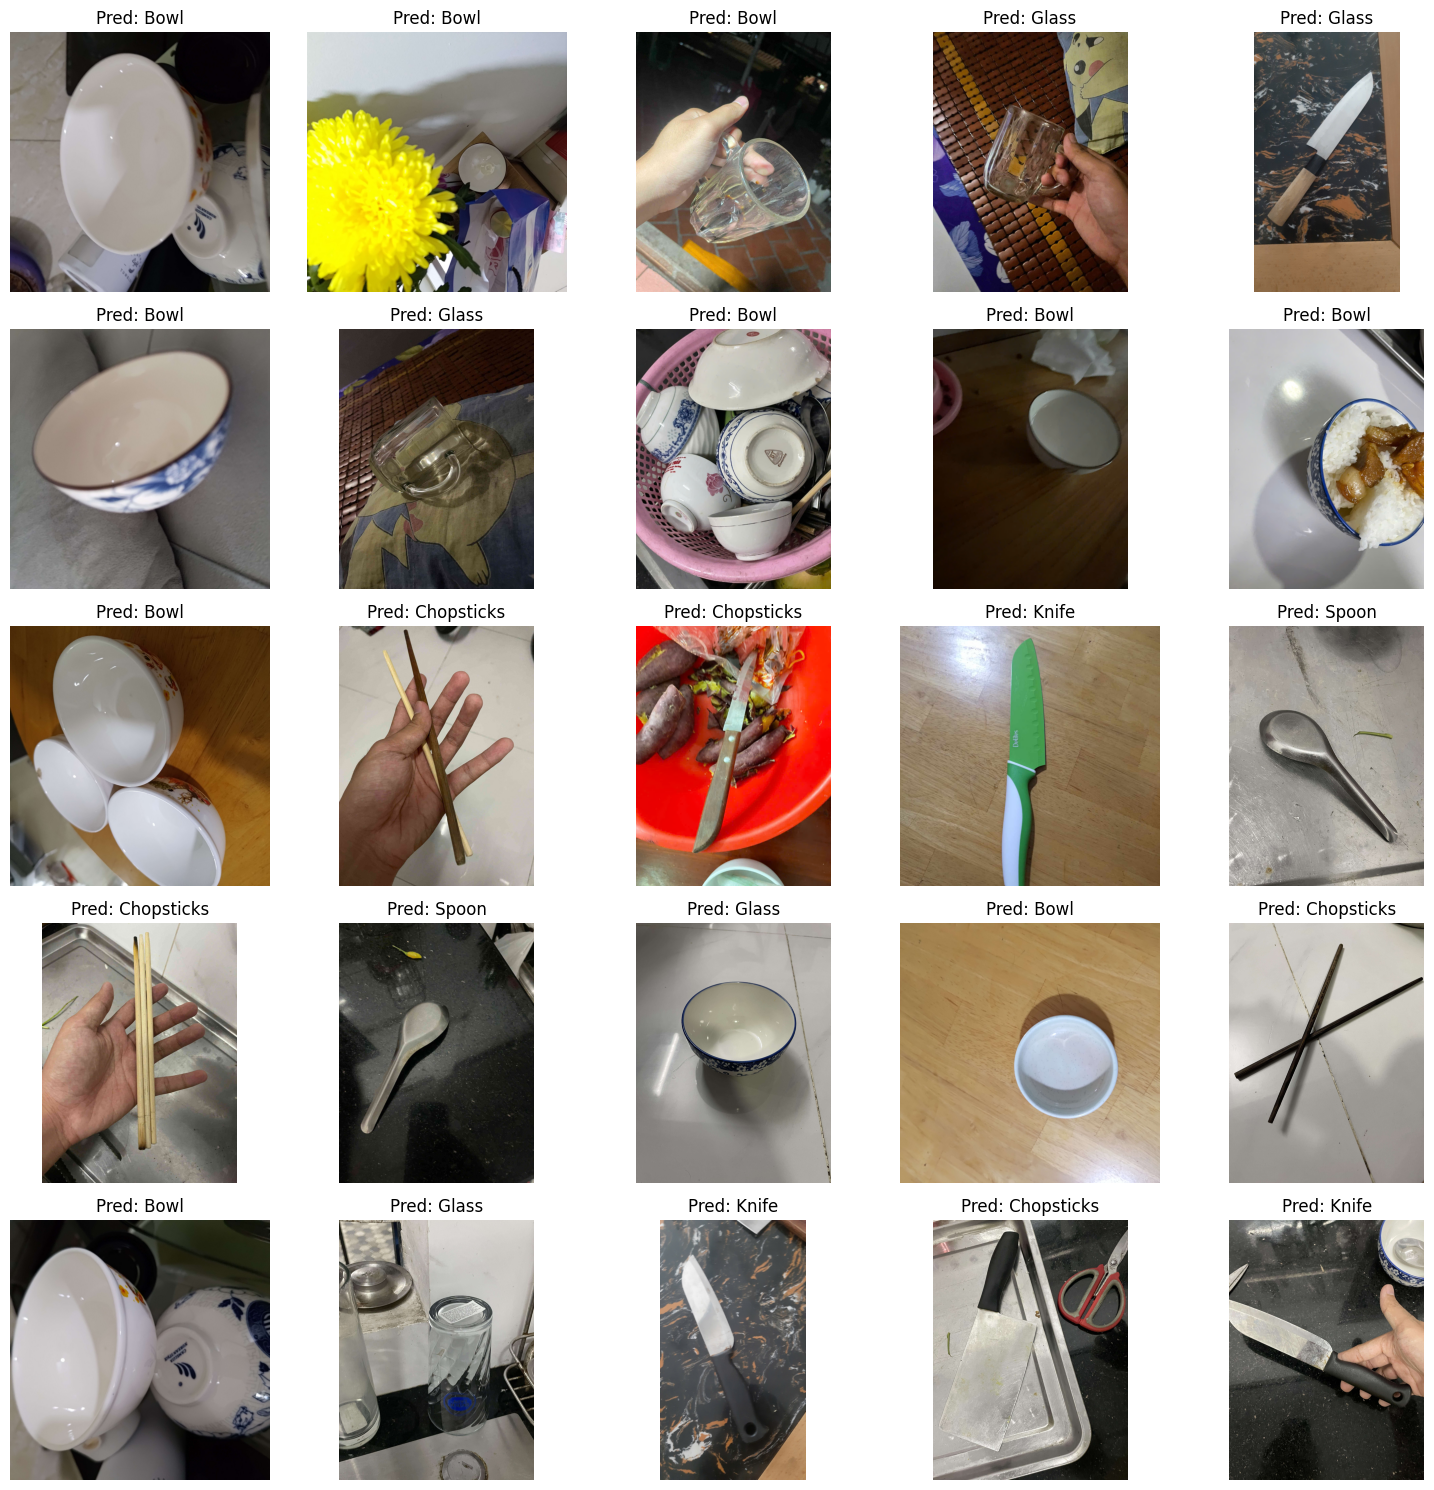

In [ ]:
# 5. Hàm tiền xử lý và dự đoán ảnh
import random
from PIL import Image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image

def predict_image(model, image_path, label_encoder):
    model.eval()
    image = preprocess_image(image_path)
    image = image.to(device)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return label_encoder.inverse_transform([predicted.item()])[0]

# 6. Chọn ngẫu nhiên 25 ảnh từ thư mục Test và dự đoán
test_dir = '/content/drive/MyDrive/Kitchen_items/Test'
all_images = [os.path.join(test_dir, img) for img in os.listdir(test_dir) if img.endswith(('.jpg', '.png', '.jpeg'))]
selected_images = random.sample(all_images, min(25, len(all_images)))  # Chọn 25 ảnh ngẫu nhiên

# Dự đoán và lưu kết quả
predictions = []
original_images = []
for img_path in selected_images:
    pred_label = predict_image(alexnet, img_path, label_encoder)
    predictions.append(pred_label)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    original_images.append(img)

# 7. Hiển thị kết quả bằng matplotlib
plt.figure(figsize=(15, 15))
for i in range(len(selected_images)):
    plt.subplot(5, 5, i + 1)
    plt.imshow(original_images[i])
    plt.title(f"Pred: {predictions[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:

correct = 0
total = 0
alexnet.eval()
with torch.no_grad():
  for data in test_loader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = alexnet(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

# Save model
PATH = '/content/drive/MyDrive/Model/AlexNet.pth'
os.makedirs(os.path.dirname(PATH), exist_ok=True)
torch.save(alexnet.state_dict(), PATH)

net = alexnet
net.load_state_dict(torch.load(PATH, map_location=device))
net.to(device)


Accuracy of the network on the test images: 97 %


<ipython-input-27-5078dc7cda45>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(PATH, map_location=device))


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#Resnet18
# Thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Chuyển nhãn thành số
label_encoder = LabelEncoder()
Z_encoded = label_encoder.fit_transform(Z)
Z_tensor = torch.tensor(Z_encoded, dtype=torch.long)

# 2. Data Augmentation
transform = {
    "train": transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(60),
        transforms.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.3),
        transforms.RandomAffine(degrees=0, translate=(0.3, 0.3), shear=20),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.7, scale=(0.02, 0.3), ratio=(0.3, 3.3)),
    ]),
    "val": transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}
X_train, X_temp, y_train, y_temp = train_test_split(X, Z_tensor, test_size=0.3, random_state=42, stratify=Z_tensor)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:

# Custom Dataset
class KitchenDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = KitchenDataset(X_train, y_train, transform=transform["train"])
val_dataset = KitchenDataset(X_val, y_val, transform=transform["val"])
test_dataset = KitchenDataset(X_test, y_test, transform=transform["test"])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




In [ ]:
from torchvision import models
# 4. Tải và tùy chỉnh ResNet-18
resnet18 = models.resnet18(pretrained=True)
num_features = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 5)
)

for name, param in resnet18.named_parameters():
    if "layer3" not in name and "layer4" not in name and "fc" not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

#resnet18.load_state_dict(torch.load('/content/drive/MyDrive/bestmodel/resnet18_best_model.pth'))

resnet18 = resnet18.to(device)
summary(resnet18, (3, 224, 224))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
#resnet18.load_state_dict(torch.load('resnet18_best_model.pth', weights_only=True))
# 5. Loss và Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet18.parameters()), lr=0.00001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# 6. Huấn luyện mô hình
train_losses = []
val_losses = []
train_accs = []
val_accs = []

num_epochs = 100
best_val_loss = float('inf')
patience = 10
counter = 0

for epoch in range(num_epochs):
    resnet18.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    resnet18.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(resnet18.state_dict(), '/content/drive/MyDrive/bestmodel/resnet18_best_model.pth')
    else:
        counter += 1
    if counter >= patience:
        print("Early stopping triggered")
        break


Epoch 1/100, Train Loss: 1.4029, Train Acc: 45.01%, Val Loss: 0.8620, Val Acc: 81.73%
Epoch 2/100, Train Loss: 0.9101, Train Acc: 72.83%, Val Loss: 0.4216, Val Acc: 89.87%
Epoch 3/100, Train Loss: 0.6365, Train Acc: 80.69%, Val Loss: 0.3234, Val Acc: 90.60%
Epoch 4/100, Train Loss: 0.5242, Train Acc: 82.54%, Val Loss: 0.2757, Val Acc: 91.47%
Epoch 5/100, Train Loss: 0.4642, Train Acc: 84.44%, Val Loss: 0.2592, Val Acc: 91.60%
Epoch 6/100, Train Loss: 0.4182, Train Acc: 86.01%, Val Loss: 0.2190, Val Acc: 93.20%
Epoch 7/100, Train Loss: 0.3863, Train Acc: 87.21%, Val Loss: 0.1903, Val Acc: 93.93%
Epoch 8/100, Train Loss: 0.3655, Train Acc: 88.13%, Val Loss: 0.1656, Val Acc: 94.53%
Epoch 9/100, Train Loss: 0.3491, Train Acc: 88.01%, Val Loss: 0.1694, Val Acc: 94.73%
Epoch 10/100, Train Loss: 0.3307, Train Acc: 88.79%, Val Loss: 0.1650, Val Acc: 94.73%
Epoch 11/100, Train Loss: 0.3172, Train Acc: 89.14%, Val Loss: 0.1605, Val Acc: 94.80%
Epoch 12/100, Train Loss: 0.3046, Train Acc: 89.46%,

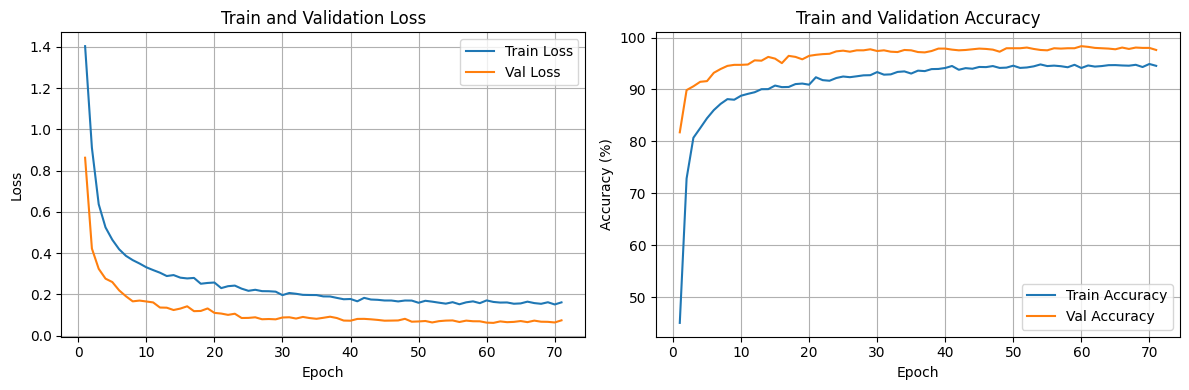

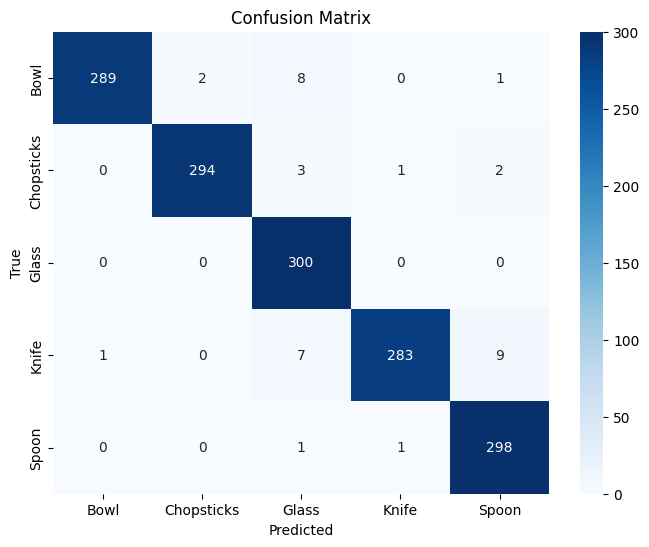


Classification Report:
              precision    recall  f1-score   support

        Bowl       1.00      0.96      0.98       300
  Chopsticks       0.99      0.98      0.99       300
       Glass       0.94      1.00      0.97       300
       Knife       0.99      0.94      0.97       300
       Spoon       0.96      0.99      0.98       300

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 8. Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 9. Classification Report (bao gồm Recall)
print("\nClassification Report:")
print(classification_report(val_labels, val_preds, target_names=label_encoder.classes_))

In [ ]:

# 7. Đánh giá trên tập test
resnet18.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = 100 * test_correct / test_total
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 98.13%


In [ ]:
# 5. Hàm tiền xử lý và dự đoán ảnh
import random
from PIL import Image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image

def predict_image(model, image_path, label_encoder):
    model.eval()
    image = preprocess_image(image_path)
    image = image.to(device)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return label_encoder.inverse_transform([predicted.item()])[0]

# 6. Chọn ngẫu nhiên 25 ảnh từ thư mục Test và dự đoán
test_dir = '/content/drive/MyDrive/Kitchen_items/Test'
all_images = [os.path.join(test_dir, img) for img in os.listdir(test_dir) if img.endswith(('.jpg', '.png', '.jpeg'))]
selected_images = random.sample(all_images, min(25, len(all_images)))  # Chọn 25 ảnh ngẫu nhiên

# Dự đoán và lưu kết quả
predictions = []
original_images = []
for img_path in selected_images:
    pred_label = predict_image(resnet18, img_path, label_encoder)
    predictions.append(pred_label)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    original_images.append(img)

# 7. Hiển thị kết quả bằng matplotlib
plt.figure(figsize=(15, 15))
for i in range(len(selected_images)):
    plt.subplot(5, 5, i + 1)
    plt.imshow(original_images[i])
    plt.title(f"Pred: {predictions[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
